In [ ]:
pip install numpy matplotlib opencv-python scikit-image pyvista

/home/wiki/miniconda3/envs/bin2-jupyter/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vuetify' from 'trame.widgets' (/home/wiki/miniconda3/envs/bin2-jupyter/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


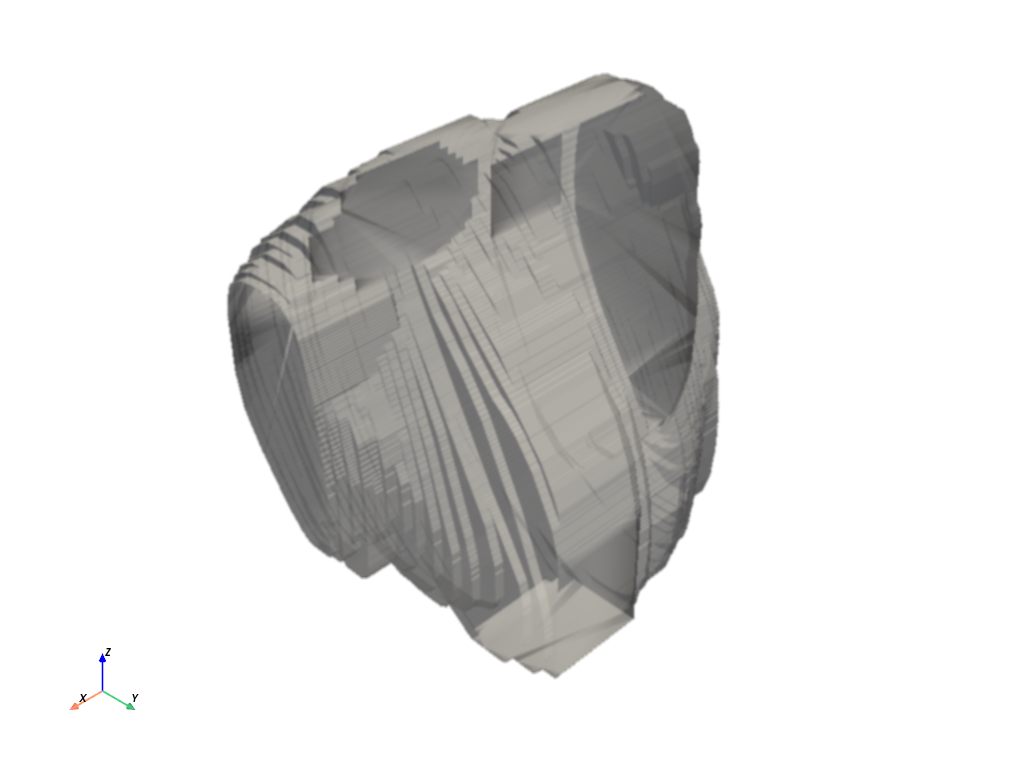

Volume: 265.79 mm³


In [1]:
import json
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure
import pyvista as pv
from scipy.ndimage import binary_dilation, zoom

# Load annotation file in COCO format which includes segmentation data
with open('1339_16.03_sg/_annotations.coco.json', 'r') as file:
    data = json.load(file)
  
# Helper functions to get width, height and id of images
def get_img(id):
    return next((item for item in data["images"] if item["id"] == id), None)

def get_img_id(id):
    image_id = get_img(id)
    return image_id["id"]

def get_img_height(id):
    img_height = get_img(id)
    return img_height["height"]

def get_img_width(id):
    img_width = get_img(id)
    return img_width["width"]

# Function which creates empty binary mask (filled with 0) with image dimensions
def mask_filled_with_0(id):
    height = get_img_height(id)
    width = get_img_width(id)
    mask = np.zeros((height, width), dtype=np.uint8)
    return mask

# Function which gets all the annotations for particular image (id)
def get_annotations_for_img_id(id):
    return [annotation for annotation in data["annotations"] if annotation["image_id"] == id]

# Function which extracts segmentation points for particular image (id)
def get_img_segmentations(id):
    annotations = get_annotations_for_img_id(id)
    segmentations = []
    for value in annotations:
        segmentations.append(value["segmentation"][0])
    return segmentations

# Function which creates binary mask depending on segmentation points (1-object, 0-background)
def binary_mask(id):
    mask = mask_filled_with_0(id)
    segmentations = get_img_segmentations(id)
    for value in segmentations:
        contur = np.array(value).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [contur], color=1)
    return mask

# Function which extracts slice number from the image name
def number_of_slice(name):
    base = name.rsplit('.', 1)[0]      # remove extension
    m = re.search(r'(\d+)$', base)     # digits at the end
    if not m:
        raise ValueError(f"Brak numeru slice w nazwie pliku: {name}")
    return int(m.group(1))

# Sort images based on slice number
all_ids = [item["id"] for item in data["images"]]
sorted_img = sorted(
    all_ids,
    key=lambda id: number_of_slice(get_img(id)["extra"]["name"])
)

# Stack all images into one 3D volume
masks_stack = [binary_mask(slice_id) for slice_id in sorted_img]
volume_3d = np.stack(masks_stack, axis=0).astype(np.float32)  # (Z, Y, X)
n_slices, height_px, width_px = volume_3d.shape


coords = np.argwhere(volume_3d > 0)
z0, y0, x0 = coords.min(axis=0)
z1, y1, x1 = coords.max(axis=0) + 1

volume_3d = volume_3d[z0:z1, y0:y1, x0:x1]

STEP_SIZE_MM = 0.2032             # 3D-Step-Size
BMODE_DEPTH_MM = 13.7360715866089   # B-Mode_Depth from Vevolab
BMODE_WIDTH_MM = 14.0524999238551   # B-Mode_Width from Vevolab

pixelsize_new_y = BMODE_DEPTH_MM / height_px
pixelsize_new_x = BMODE_WIDTH_MM / width_px
slice_thickness_new = STEP_SIZE_MM / 4.0  # increase slices in Z-axis 4 times

# Interpolation factor in Z
factor_z = 4.0
interpolated_data = zoom(volume_3d, (factor_z, 1.0, 1.0), order=1)

# Convert interpolated data to binary
interpolated_data_binary = (interpolated_data > 0.1).astype(np.uint8)

# 3D mask expansion - voxels on edges
interpolated_data_edges = binary_dilation(
    interpolated_data_binary,
    structure=np.ones((3, 3, 3)),
).astype(np.uint8)


for _ in range(16):
    interpolated_data_edges = binary_dilation(
        interpolated_data_edges,
        structure=np.ones((3, 3, 3))
    )

# 3D mesh reconstruction with marching cubes
vertices, faces, normals, values = measure.marching_cubes(
    interpolated_data_edges,
    level=0.5,
    spacing=(slice_thickness_new, pixelsize_new_x, pixelsize_new_y)
)

# Convert into PyVista format
faces_pv = np.hstack([[3, *face] for face in faces])
surf = pv.PolyData(vertices, faces_pv)

# Fill holes in the mesh surface
size=100
surf_filled = surf.fill_holes(hole_size=size)

# Visualise the mesh
plotter = pv.Plotter()
plotter.add_mesh(surf_filled, color="lightgray", opacity=0.7, smooth_shading=True, show_edges=False)
plotter.add_blurring()
plotter.add_axes()
plotter.camera_position = "iso"
# plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# Calculate volume based on voxels number
voxel_volume = pixelsize_new_x * pixelsize_new_y * slice_thickness_new
voxels_number = np.count_nonzero(interpolated_data_edges)
volume_mm3 = voxels_number * voxel_volume
print("Volume:", round(volume_mm3, 2), "mm³")